1. **State**

    Start by defining the State of the graph.

    This state schema acts as the input structure for all Nodes and Edges within the graph.

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [2]:
def node1(state):
    print("----Node1----")
    return {"graph_state": state["graph_state"] + " " + "welcome"}

def node2(state):
    print("----Node2----")
    return {"graph_state": state["graph_state"] + " to the DataHack Summit!"}

def node3(state):
    print("----Node3----")
    return {"graph_state": state["graph_state"] + " Enjoy the event!"}

In [3]:
import random
from typing import Literal

def decide_node(state) -> Literal["node2", "node3"]:
    user_input = state["graph_state"]

    if random.random() < 0.5:
        return "node2"
    
    return "node3"

In [4]:
decide_node({"graph_state":"Taha"})

'node3'

In [14]:
pip install langchain_groq

  Attempting uninstall: groq
    Found existing installation: groq 0.29.0
    Uninstalling groq-0.29.0:
      Successfully uninstalled groq-0.29.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**StateGraph**

    It is used to tell that how the graph state will be , tell the type of node all share


**Defining Nodes**

    .add_node is used to define the nodes with there names and original python functions

**Defining Edges**

1) the edge is used to connect how the node will be execute , like the node with the start always execution of a    graph start from there

2) the add_conditional_edges is used to decide where to go after start ,mostly we add there our logic to redirect on which node after the start of graph

3) the node with ends tell that if graph comes on them the node executes and end the graph

**Compile of Graph**

   This freezes the design into an executable graph.


**Invoking graph**

    Means how to run a graph , we use graph.invoke, like this
    graph = builder.compile()
    graph.invoke(user_input)


In [8]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image, display
builder = StateGraph(State)

#defining Nodes
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

#logic - Defining Edges
builder.add_edge(START,"node1")
builder.add_conditional_edges("node1",decide_node)
builder.add_edge("node2",END)
builder.add_edge("node3",END)

# compile the graph
graph = builder.compile()


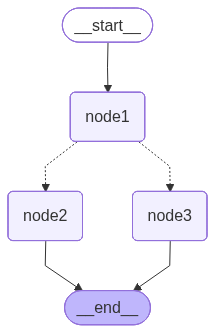

In [ ]:
graph

In [9]:
graph.invoke({"graph_state":"Taha"})

----Node1----
----Node3----


{'graph_state': 'Taha welcome Enjoy the event!'}

Let's build a simple chain that combines 4 concepts:

Using chat messages as our graph state

Using chat models in graph nodes

Binding tools to our chat model


Executing tool calls in graph nodes

**1. Messages**

Chat models can handle different types of messages representing various roles in a conversation. LangChain supports key message types like:

HumanMessage - from the user

AIMessage - from the chat model

SystemMessage - to guide the model's behavior

ToolMessage - responses from tool calls

Let's build a list of messages. Each message can include:

content - the message text

name - optional author name

response_metadata - optional metadata (e.g. from model providers for AIMessage, like OpenAI)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content="Hello, I'm your virtual travel assistant for Bengaluru. How can I help you plan your visit?", name="Agent")]
messages.append(HumanMessage(content="Hi, I'm visiting Bengaluru for the first time. Can you suggest key places to see?", name="Miguel"))
messages.append(AIMessage(content="Certainly. Some must-visit places include Lalbagh Botanical Garden, Bangalore Palace, and Cubbon Park. Are you interested in cultural sites, nature, or food experiences?", name="Agent"))
messages.append(HumanMessage(content="I'm interested in a mix of history and local cuisine.", name="Miguel"))
messages.append(AIMessage(content="Great choice. You can explore Tipu Sultan's Summer Palace for history, then head to VV Puram Food Street for authentic local dishes.", name="Agent"))


In [16]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Hello, I'm your virtual travel assistant for Bengaluru. How can I help you plan your visit?
================================ Human Message =================================
Name: Miguel

Hi, I'm visiting Bengaluru for the first time. Can you suggest key places to see?
================================== Ai Message ==================================
Name: Agent

Certainly. Some must-visit places include Lalbagh Botanical Garden, Bangalore Palace, and Cubbon Park. Are you interested in cultural sites, nature, or food experiences?
================================ Human Message =================================
Name: Miguel

I'm interested in a mix of history and local cuisine.
================================== Ai Message ==================================
Name: Agent

Great choice. You can explore Tipu Sultan's Summer Palace for history, then head to VV Puram Food Street for authentic local dishe

In [ ]:
import os
os.environ["GROQ_API_KEY"] = "your key"
print("Groq key:", os.getenv("GROQ_API_KEY"))

Groq key: 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


In [18]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = "llama-3.3-70b-versatile",temperature=0)
result = llm.invoke(messages)


c:\Users\taham\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
type(result)

langchain_core.messages.ai.AIMessage

In [20]:
result.pretty_print()

================================== Ai Message ==================================

 Don't miss the ISKCON Temple and try some traditional South Indian cuisine at MTR (Mavalli Tiffin Room) or Sri Sagar. Would you like more recommendations or help with planning your itinerary?


In [21]:
result.content

" Don't miss the ISKCON Temple and try some traditional South Indian cuisine at MTR (Mavalli Tiffin Room) or Sri Sagar. Would you like more recommendations or help with planning your itinerary?"

**Tools**

Tools are valuable when you need a model to interact with external systems.

These systems (such as APIs) typically expect structured inputs rather than natural language.

By binding an API as a tool, you make the model aware of the expected input format.

The model decides when to call a tool based on the user's natural language input, and the output will follow the tool's defined schema.

Many LLM providers now support tool calling, and LangChain offers a straightforward interface for it.

You can bind any Python function using ChatModel.bind_tools(function).

Let's showcase a very simple example of tool calling. The multiply function is our tool.



In [22]:
def multiple(a:int,b:int) -> int:
    return a*b

llm_with_tools = llm.bind_tools([multiple])

In [23]:
no_tool_call = llm_with_tools.invoke(
    [HumanMessage(content = "What is the way to Bangalore from Chennai?",name = "Miguel")]
)

In [24]:
no_tool_call.pretty_print()

================================== Ai Message ==================================

You can take a flight from Chennai International Airport to Kempegowda International Airport in Bangalore. Alternatively, you can take a train from Chennai Central Railway Station to Bangalore City Railway Station, or drive via the NH48 highway, which is approximately 346 kilometers and takes around 6 hours by car, depending on traffic conditions. Additionally, you can also take a bus from Chennai to Bangalore, which is operated by various private and government bus services.


In [25]:
no_tool_call.content

'You can take a flight from Chennai International Airport to Kempegowda International Airport in Bangalore. Alternatively, you can take a train from Chennai Central Railway Station to Bangalore City Railway Station, or drive via the NH48 highway, which is approximately 346 kilometers and takes around 6 hours by car, depending on traffic conditions. Additionally, you can also take a bus from Chennai to Bangalore, which is operated by various private and government bus services.'

In [26]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content = f"What is 2 multiplied by 3",name = "Miguel")]
)

In [27]:
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiple (q3kjvsk2a)
 Call ID: q3kjvsk2a
  Args:
    a: 2
    b: 3


In [28]:
#no content as the tool call was used
tool_call.content

''

In [29]:
tool_call.tool_calls

[{'name': 'multiple',
  'args': {'a': 2, 'b': 3},
  'id': 'q3kjvsk2a',
  'type': 'tool_call'}]

Unlike the example graph we saw earlier, in this case we need to use messages (the message history) within the state.

If we wanted to handle this manually, we'd need to create another TypedDict with a messages property.

Fortunately, LangGraph already provides a built-in state type for this: MessagesState.

The cool thing about this class is that it already incorporates a reducer. This reducer logic will take care of appending the new message to the message list.

All of these operations will be perform by LangGraph under the hood

In [30]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

**Building the Graph**


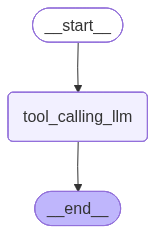

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END

def tool_calling_llm(state:MessagesState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START,"tool_calling_llm")
builder.add_edge("tool_calling_llm",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


We've implemented a very simple chain!

If we pass a general message (unrelated to math operations), the LLM will respond without any tool call.

In [32]:
messages = graph.invoke({"messages":HumanMessage(content = "Hey there ! i am taha")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey there ! i am taha
================================== Ai Message ==================================

It's nice to meet you, Taha. Is there something I can help you with or would you like to chat?


In [33]:

messages = graph.invoke({"messages": HumanMessage(content="Multiply 10 and 3")})
for m in messages['messages']:
    m.pretty_print()
     

================================ Human Message =================================

Multiply 10 and 3
================================== Ai Message ==================================
Tool Calls:
  multiple (86zgfs64z)
 Call ID: 86zgfs64z
  Args:
    a: 10
    b: 3


**📓 Exercise 1**
We need to create a chain that is able to calculate this operation:

"Add two numbers (a, b) and then divide the result by c"

So, these are the things you need to consider:

Implement a tool with the logic of the operation

Bind the Tool to the LLM

Build a Chain with LangGraph that is able to call this LLM with Tool

In [34]:
def tool(a:int,b:int,c:int):
    return (a+b)/c

In [35]:
llm_with_tools = llm.bind_tools([tool])

tool_call = llm_with_tools.invoke([
    HumanMessage(content="What is the result of (10 + 5) / 3?")
])


In [36]:
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tool (ajj3qx3z4)
 Call ID: ajj3qx3z4
  Args:
    a: 10
    b: 5
    c: 3


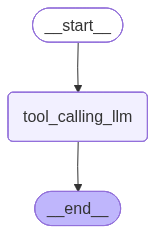

In [37]:
def tool_calling_llm(state:MessagesState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

class MessagesState(MessagesState):
    pass

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START,"tool_calling_llm")
builder.add_edge("tool_calling_llm",END)    

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages = graph.invoke({"messages": HumanMessage(content="Add 10 and 12 and then divide by 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 12 and then divide by 2
================================== Ai Message ==================================
Tool Calls:
  tool (sdekhvy8y)
 Call ID: sdekhvy8y
  Args:
    a: 10
    b: 12
    c: 2


**Router**

You can think of this as a router, where the chat model decides—based on user input—whether to respond directly or to call a tool.

This represents a basic form of an agent, where the LLM manages control flow by choosing between tool invocation and generating a direct reply.

In [39]:
from langchain_groq import ChatGroq

def multiply(a:int,b:int):
    """

    Args:
        a (int): first int
        b (int): second int
    """
    return a*b

llm = ChatGroq(model = "llama-3.3-70b-versatile",temperature=0)
llm_with_tools = llm.bind_tools([multiply])

We use the built-in ToolNode and simply pass a list of our tools to initialize it.

We use the built-in tools_condition as our conditional edge.

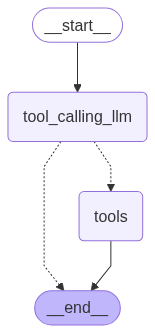

In [ ]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


def tool_calling_llm(state:MessagesState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode([multiply])) #it will run the function and get args created by LLM

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
     

In [ ]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 add by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (y6zvyabr9)
 Call ID: y6zvyabr9
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


**📓 Exercise 2**

Suppose we need to two additional tools. A divide and add tool. How would you do it?

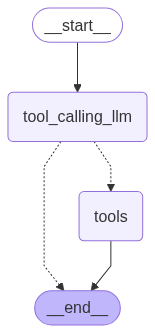

In [54]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


llm = ChatGroq(model="llama-3.3-70b-versatile")
llm_with_tools = llm.bind_tools([multiply, add, divide])

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, add, divide]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:

messages = [HumanMessage(content="Hello, what is 8 divided by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 8 divided by 2?
================================== Ai Message ==================================
Tool Calls:
  divide (48c802vw3)
 Call ID: 48c802vw3
  Args:
    a: 8
    b: 2
================================= Tool Message =================================
Name: divide

4.0
